# Practice 10: Word Cloud
The following code generates a MisprofesoresFCFM comments word cloud. 

In [1]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests as rq
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy

In [2]:
#Ruta donde se guardan los archivos generados
route = "C:/Users/Miguel Sanka/Desktop/"

In [ ]:
# Función para generar un dataframe con la información de los maestros de MisprofesoresFCFM
def generate_table_prof(url: str) -> pd.DataFrame:
    web_mis_prof = rq.get(url)
    soup_mis_prof = bs(web_mis_prof.content, "html.parser")
    
    js_code = soup_mis_prof.find_all("script", type="text/javascript")
    str_dataset = re.search(r'var dataSet = (.*?);', str(js_code)).group(1)
    dataset = json.loads(str_dataset)
    df_prof = pd.DataFrame(dataset)
    df_prof.rename(columns={'i':"ID", 'n':"Name", 'a':"Last name(s)", 'd':"Department/Faculty", 'm':"Grades", 'c':"Mean"}, inplace=True)

    df_prof['Name']= df_prof['Name'].str.title()
    df_prof['Last name(s)']= df_prof['Last name(s)'].str.title()
    df_prof["Source"] =  df_prof["Name"] + '-' + df_prof["Last name(s)"] + '_' + df_prof["ID"] 
    df_prof["Source"] = "https://www.misprofesores.com/profesores/" + df_prof["Source"].str.replace(' ', '-')
    
    dic = []
    reco = []
    for prof_url in df_prof["Source"]:
        web_prof = rq.get(prof_url)
        soup_prof = bs(web_prof.content, "html.parser")

        reco_percent = soup_prof.find_all("div", attrs={"class": "grade"})[1].text
        reco_percent = reco_percent.replace(' ', '').replace('\n', '').replace('%', '')
        reco.append(reco_percent)

        difficulty = soup_prof.find_all("div", attrs={"class": "grade"})[2].text
        difficulty = difficulty.replace(' ', '').replace('\n', '').replace('%', '')
        dic.append(difficulty)

    df_prof["Recommendation"] = reco
    df_prof["Dificulty"] = dic

    df_prof = df_prof.reindex(columns=["ID", "Name", "Last name(s)", "Department/Faculty", "Grades", "Mean", "Recommendation", "Dificulty", "Source"])
    df_prof["Recommendation"]  = df_prof["Recommendation"].replace('',0)
    df_prof = df_prof.astype({"Grades":"int", "Mean":"float64", "Recommendation":"float64", "Dificulty":"float64"})
    # df_prof["Name"] = df_prof["Name"].title()
    return df_prof

In [ ]:
# Función para generar una lista de los comentarios de MisprofesoresFCFM
def generate_list_comments(urls: pd.Series) -> list:
    comments = []
    for url in urls: 
        web_prof = rq.get(url)
        soup_prof = bs(web_prof.content, "html.parser")
        num_grades = soup_prof.find("div", attrs={"class": "table-toggle rating-count active"}).text

        num_grades = num_grades.replace('\n', '').replace(' Calificaciones de Estudiantes', '')
        num_grades = num_grades.strip()

        if num_grades == '':
            num_grades = 0
        
        i = 1
        comments_prof = []
        while int(num_grades) > len(comments_prof ):
            web_prof = rq.get(url + "?pag={}".format(i))
            soup_prof = bs(web_prof.content, "html.parser")
            tags_comments = soup_prof.find_all("p", attrs={"class": "commentsParagraph"})
            for tag in tags_comments:
                tex = tag.text.replace('\n', '').replace('\r', '')
                tex = tex.strip()
                #if(tex != ''):
                comments_prof.append(tex)
            i = i+1
        comments.extend(comments_prof)

    comments = [c for c in comments if c != '']
    
    return comments
    # pd.DataFrame(data=comments, index=None, columns=["Comment"])

In [3]:
# Función para generar word cloud
def generate_word_cloud(text: str) -> None:
    # modelo de spaCy para español
    nlp = spacy.load('es_core_news_sm') #python -m spacy download es_core_news_sm

    # Procesar la oración con spaCy
    doc = nlp(text)

    # Identificar sustantivos y adjetivos
    sustantivos = [token.text for token in doc if token.pos_ == 'NOUN' or token.pos_ == 'ADJ']
    join_sust = " ".join(sustantivos)

    #genere wc
    world_cloud = WordCloud(width = 1600, height = 800, background_color = "black",
               colormap = "rainbow")
    world_cloud.generate(join_sust)
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(world_cloud)
    plt.axis("off")
    plt.tight_layout(pad=10)
    plt.savefig(route + "Word Cloud FCFM.png", facecolor='k')

    

In [ ]:
df_fcfm = generate_table_prof("https://www.misprofesores.com/escuelas/UANL-FCFM_2263")

In [ ]:
df_fcfm_comments = generate_list_comments(df_fcfm["Source"])

In [ ]:
text = ". ".join(df_fcfm_comments)

In [ ]:
# Guardar text
with open(route + "comentarios.txt", "a") as text_file:
    text_file.write(text)

In [4]:
#Leer text
with open(route + 'comentarios.txt', 'r') as file:
    text = file.read()

In [5]:
text

'Realmente no de clase, reparte los temas entre los equipos y en base a eso da retroalimentación, super barco. Una gran maestra, pase con 10, solo es cuestión de hacer todo lo que pida la vdd creo que todo lo que pide es muy sencillo y ella es muy buena onda, te retroalimenta y platica cosas y da tips que nos pueden funcionar en unos años.. Es fácil pasar con ella y aprender mucho, pero eso sí la mayoría de los temas los impartirán en equipos, y también a veces pone a exponer en inglés.. Barcote. El semestre fue de presentaciones en equipo, el PIA también, lo que sí es que da platicas muy buenas acerca de la carrera, la asistencia se podría decir que es obligatoria ya que no graba las clases y a veces encarga trabajos en equipo para entregar en esa misma clase. Es buena, la mayoría de sus clases son platicadas, pero, muchas veces deja trabajos largos y aburridos, muchas exposiciones y tienes que participar. Se pone un poco estricta pero es bastante amigable y te saca platica a gusto.. 

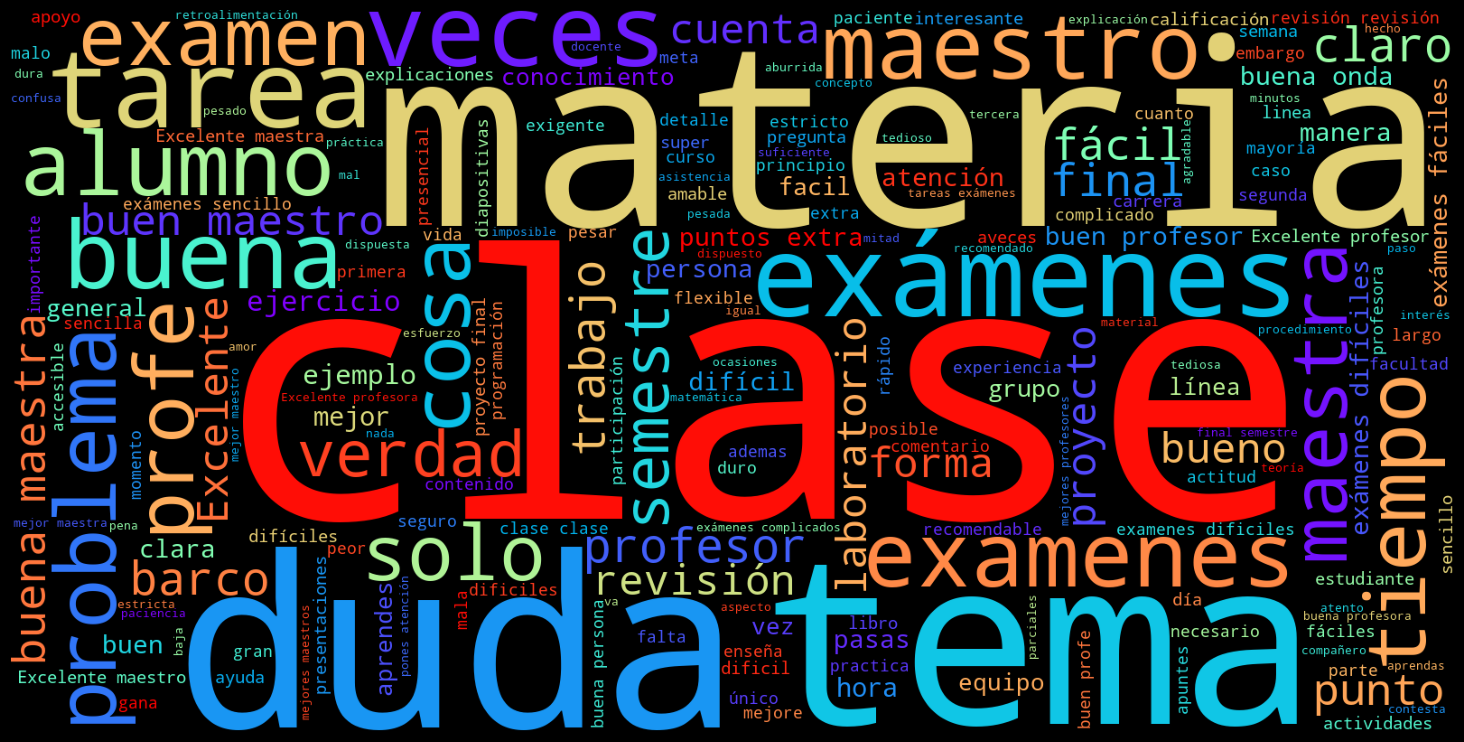

In [6]:
generate_word_cloud(text)